In [41]:
with open("seed.txt", "r") as f:
    seed = int(f.read().strip())

print(f"seed = {seed}")

seed = 52772


In [42]:
#Task 1: Regression — Regularization on Housing Data
#1.1 1A. Data Preprocessing (Required)
#1. Use your seed to create a 60/20/20 train/validation/test split.

#load dataset
import urllib.request
import pandas as pd
import numpy as np

url = "https://lib.stat.cmu.edu/datasets/boston"
response = urllib.request.urlopen(url)
raw = response.read().decode()
lines = raw.strip().splitlines()
data_lines = lines[22:] #dataset starts from line 23 

dataset = []

#each data contains 2 lines
for i in range(0, len(data_lines), 2):
    line1 = data_lines[i].strip().split()
    line2 = data_lines[i+1].strip().split()
    dataset.append(line1 + line2)

column_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM",
    "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"
]

df = pd.DataFrame(dataset, columns=column_names).astype(float)

#display(df)

total_rows = len(df)
print(f"Total rows in dataset: {total_rows}")

np.random.seed(seed)
indices = np.random.permutation(total_rows)

train_end = int(0.6 * total_rows)
validation_end = int(0.8 * total_rows)

train_index = indices[:train_end] #60%
validation_index   = indices[train_end:validation_end] #20%
test_index  = indices[validation_end:] #20%

train_df = df.iloc[train_index]
validation_df   = df.iloc[validation_index]
test_df  = df.iloc[test_index]

#verify split correctly
print(f"Train set: {len(train_df)} rows,", f"Validation set: {len(validation_df)} rows,", f"Test set: {len(test_df)}")
print(f"Train: {len(train_df)/len(df)*100:.1f}%, ", f"Validation: {len(validation_df)/len(df)*100:.1f}%, ", f"Test: {len(test_df)/len(df)*100:.1f}%")


Total rows in dataset: 506
Train set: 303 rows, Validation set: 101 rows, Test set: 102
Train: 59.9%,  Validation: 20.0%,  Test: 20.2%


In [43]:
#2. Handle missing values (if any) and apply appropriate transformations:
#• If categorical columns exist: apply one-hot encoding.

df.isnull().sum()
#So there is no missing values in this dataset

categorical_columns = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print(categorical_columns)
#categorical_columns is empty, so there is no categorical columns in this dataset


#• Create two interaction features of your choice; justify why they may help.

# RM(average number of rooms per dwelling)and LSTAT(% lower status of the population) are two interaction features. 
# In a high-status neighborhood, where LSTAT is low, an extra room can add a lot of value. However, in a low-status area,
# where LSTAT is high, an extra room may only add little value. So in the model, we want to show that the effect of room 
# numbers depends on the LSTAT. Adding the interaction RM × LSTAT to capture non-additive effects between house size and 
# neighborhood socioeconomic status can improve model expressiveness. 



[]


In [44]:
#3. Run the full pipeline under three scaling settings:

X_train = train_df.to_numpy(dtype=float)
X_validation = validation_df.to_numpy(dtype=float)
X_test = test_df.to_numpy(dtype=float)

#(a) No scaling
train_no_scale, validation_no_scale, test_no_scale = X_train, X_validation, X_test

#(b) Standard scaling (z-score)
def standard_scaler_fit(X_train):
    mu = X_train.mean(axis=0)
    sigma = X_train.std(axis=0, ddof=0)
    sigma[sigma == 0] = 1.0  # signma cannot be zero
    return mu, sigma

def standard_scaler_transform(X, mu, sigma):
    return (X - mu) / sigma

mu, sigma = standard_scaler_fit(X_train)

train_standard_scaling = standard_scaler_transform(X_train, mu, sigma)
validation_standard_scaling = standard_scaler_transform(X_validation, mu, sigma)
test_standard_scaling = standard_scaler_transform(X_test, mu, sigma)

#(c) Robust scaling (median/IQR)
def robust_scaler_fit(X_train):
    median = np.median(X_train, axis=0)
    q1 = np.percentile(X_train, 25, axis=0)
    q3 = np.percentile(X_train, 75, axis =0)
    iqr =  q3 - q1
    iqr[iqr == 0] = 1 # iqr cannot be zero
    return median, iqr

def robust_scaler_transform(X, median, iqr):
    return (X-median) / iqr

median, iqr = robust_scaler_fit(X_train)

train_robust_scaling = robust_scaler_transform(X_train, median, iqr)
validation_robust_scaling = robust_scaler_transform(X_validation, median, iqr)
test_robust_scaling = robust_scaler_transform(X_test, median, iqr)

print("No Scaling: ", train_no_scale.shape, validation_no_scale.shape, test_no_scale.shape)
print("Standard Scaling: ", train_no_scale.shape, validation_no_scale.shape, test_no_scale.shape)
print("Robust Scaling: ", train_no_scale.shape, validation_no_scale.shape, test_no_scale.shape)


No Scaling:  (303, 14) (101, 14) (102, 14)
Standard Scaling:  (303, 14) (101, 14) (102, 14)
Robust Scaling:  (303, 14) (101, 14) (102, 14)


Condition number κ(X^T X):
  Before scaling (no scaling):  7.2887e+07
  After standard scaling:       1.2544e+02
  After robust scaling:         1.2544e+02
Top 10 correlation features:  [('RAD', 'TAX', 0.93), ('INDUS', 'NOX', 0.77), ('NOX', 'DIS', 0.77), ('LSTAT', 'MEDV', 0.74), ('NOX', 'AGE', 0.73), ('AGE', 'DIS', 0.73), ('INDUS', 'TAX', 0.7), ('INDUS', 'DIS', 0.69), ('NOX', 'TAX', 0.67), ('ZN', 'DIS', 0.65)]


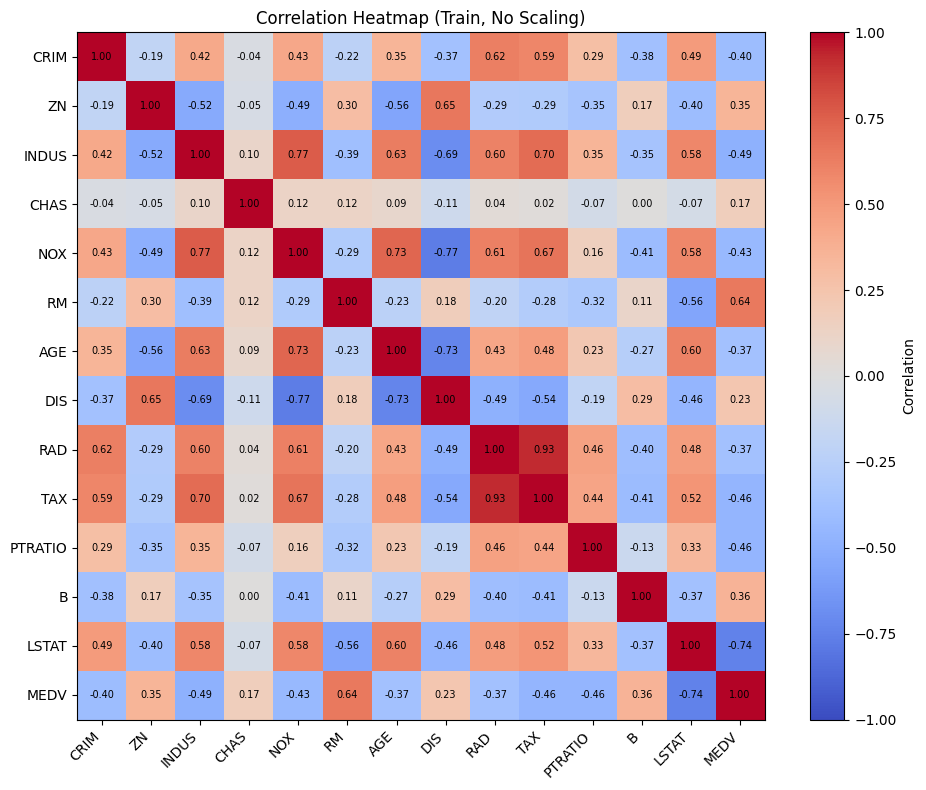

In [62]:
#4. Compute and report:
#• Condition number κ(X⊤X) (np.linalg.cond(XtX)) before and after scaling

def condition_number(X):
    """Compute κ(X^T X) for design matrix X."""
    XtX = X.T @ X
    return np.linalg.cond(XtX)

kappa_no_scale = condition_number(train_no_scale)
kappa_standard = condition_number(train_standard_scaling)
kappa_robust = condition_number(train_robust_scaling)

print("Condition number κ(X^T X):")
print(f"  Before scaling (no scaling):  {kappa_no_scale:.4e}")
print(f"  After standard scaling:       {kappa_standard:.4e}")
print(f"  After robust scaling:         {kappa_robust:.4e}")

# Top-10 absolute correlations among features(heatmap allowed)
correlation_matrix = np.corrcoef(train_no_scale.T)  # (n_features, n_features)
number_of_features = corr_matrix.shape[0]

pairs = []
for i in range(number_of_features):
    for j in range(i + 1, number_of_features):
        pairs.append((column_names[i], column_names[j], float(round(abs(correlation_matrix[i, j]),2))))

pairs.sort(key=lambda x: x[2], reverse=True) #sort the pairs by the absolute correlation in descending order
top10_pairs = pairs[:10]

print("Top 10 correlation features:")
for pair in top10_pairs:
    print(pair)

#heapmap: 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)

ax.set_xticks(np.arange(number_of_features))
ax.set_yticks(np.arange(number_of_features))
ax.set_xticklabels(column_names, rotation=45, ha="right")
ax.set_yticklabels(column_names)

# colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Correlation", rotation=90)

annotate = True
if annotate:
    for i in range(number_of_features):
        for j in range(number_of_features):
            ax.text(j, i, f"{correlation_matrix[i, j]:.2f}", ha="center", va="center", fontsize=7)

ax.set_title("Correlation Heatmap (Train, No Scaling)")
plt.tight_layout()
plt.show()